# Prediction based on image encoding

## Example from lectures - MNIST

In [2]:
import numpy as np
import os
from skimage.io import imsave
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Activation, Input
from keras.callbacks import Callback

from keras.layers import Input, Dense
from keras.models import Model

np.random.seed(1337)  # for reproducibility

batch_size = 128
nb_epoch = 80

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# skaliranje na [0,1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# definisanje autoenkodera
# prvo enkoder
inpt = Input((784, ))
encoder = Dense(128)(inpt)
encoder = Activation('relu')(encoder)
encoder = Dense(32)(encoder)
encoder = Activation('relu')(encoder)

# zatim dekoder
decoder = Dense(128)(encoder)
decoder = Activation('relu')(decoder)
decoder = Dense(784)(decoder)
decoder = Activation('sigmoid')(decoder)

# povezivanje enkodera i dekodera u autoenkoder
model = Model(input=inpt, output=decoder)

model.compile(loss='binary_crossentropy', optimizer='rmsprop')

# uzimamo nasumicnih 10 primera iz testnog skupa za vizualizaciju rezultata
idx = np.random.randint(X_test.shape[0], size=(10, ))
input_vect = X_test[idx]
input_imgs = input_vect.reshape(input_vect.shape[0], 28, 28)


output_imgs_dir = 'imgs/mnist_mlp_autoencoder'
if not os.path.exists(output_imgs_dir):
    os.mkdir(output_imgs_dir)


# utility funkcija za iscrtavanje rezultata: ulazna slika -> rekonstruisana slika
def generate_images(epoch):
    output_vect = model.predict(input_vect)
    output_imgs = output_vect.reshape(output_vect.shape[0], 28, 28)
    combined_img = combine_images(input_imgs, output_imgs)

    imsave(output_imgs_dir + '/epoch_{}.jpg'.format(epoch), combined_img)


def combine_images(inpt_imgs, outpt_imgs):
    num = inpt_imgs.shape[0]
    width = num
    height = 2
    shape = inpt_imgs.shape[1:]
    image = np.zeros((height * shape[0], width * shape[1]), dtype=inpt_imgs.dtype)
    combined = np.concatenate((inpt_imgs, outpt_imgs))
    for index, img in enumerate(combined):
        i = int(index / width)
        j = index % width
        image[i * shape[0]:(i + 1) * shape[0], j * shape[1]:(j + 1) * shape[1]] = img
    return image


# Callback klasa iscrtavanje rezultata autoencodera
class CombineImagesCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        generate_images(epoch)

# obucavanje autoenkodera
model.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch,
          validation_data=(X_test, X_test), callbacks=[CombineImagesCallback()])

# Examples from Keras website

## Example 1 - the simplest autoencoder

In [1]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


In [2]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [3]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [4]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
from keras.datasets import mnist

import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.3626 - val_loss: 0.2712
Epoch 2/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.2644 - val_loss: 0.2536
Epoch 3/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.2432 - val_loss: 0.2306
Epoch 4/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.2232 - val_loss: 0.2135
Epoch 5/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.2082 - val_loss: 0.2004
Epoch 6/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1967 - val_loss: 0.1905
Epoch 7/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.1877 - val_loss: 0.1824
Epoch 8/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.1804 - val_loss: 0.1759
Epoch 9/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.1743 - val_loss: 0.1702
Epoch

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

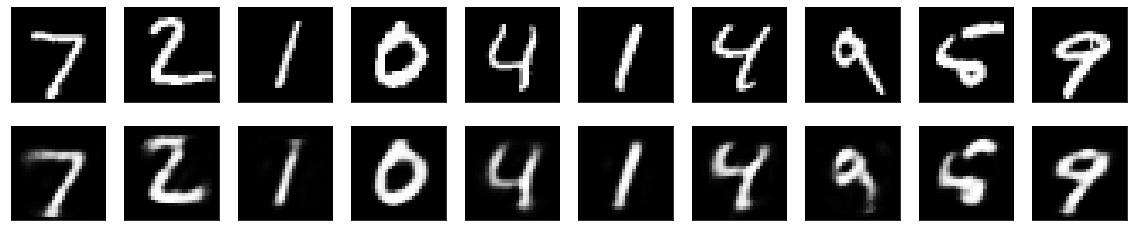

In [9]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Example 2 - convolutional autoencoder

In [10]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [11]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [62]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train.shape

(60000, 28, 28)

In [13]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 54s 894us/step - loss: 0.2144 - val_loss: 0.1681
Epoch 2/50
60000/60000 [==============================] - 51s 858us/step - loss: 0.1564 - val_loss: 0.1521
Epoch 3/50
60000/60000 [==============================] - 51s 843us/step - loss: 0.1407 - val_loss: 0.1310
Epoch 4/50
60000/60000 [==============================] - 52s 867us/step - loss: 0.1320 - val_loss: 0.1313
Epoch 5/50
60000/60000 [==============================] - 51s 854us/step - loss: 0.1268 - val_loss: 0.1235
Epoch 6/50
60000/60000 [==============================] - 50s 840us/step - loss: 0.1230 - val_loss: 0.1206
Epoch 7/50
60000/60000 [==============================] - 51s 842us/step - loss: 0.1201 - val_loss: 0.1185
Epoch 8/50
60000/60000 [==============================] - 50s 840us/step - loss: 0.1178 - val_loss: 0.1137
Epoch 9/50
60000/60000 [==============================] - 50s 840us/step - loss: 0.1161 - val_

In [36]:
# encode and decode some digits
# note that we take them from the *test* set
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

encoding_dim = 128
encoded_input = Input(shape=(encoding_dim,))

encoded_input_shape = Input(shape=(4, 4, 8)) 

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_input_shape)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input_shape, decoded)
decoded_imgs = decoder.predict(encoded_imgs)

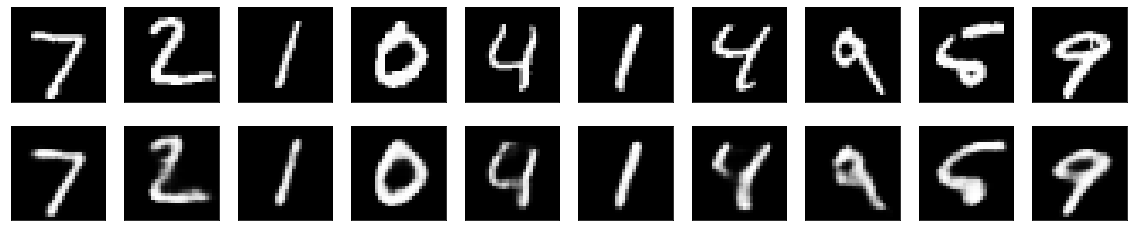

In [37]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

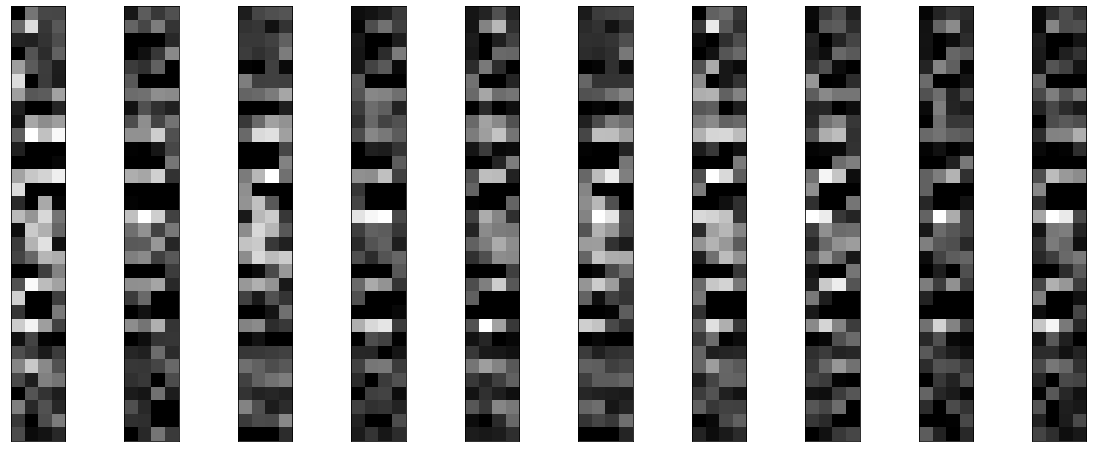

In [38]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 9gag image encoding

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.preprocessing import image

Using TensorFlow backend.


In [22]:
input_img = Input(shape=(112, 112, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional NOT

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

## VGG16 autoencoder

In [17]:
input_shape = (224, 224, 3)
input_img = Input(shape=(224, 224, 3))

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='encoder_block1_conv1')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='encoder_block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='encoder_block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='encoder_block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='encoder_block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='encoder_block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='encoder_block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='encoder_block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='encoder_block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='encoder_block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='encoder_block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='encoder_block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='encoder_block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='encoder_block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='encoder_block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='encoder_block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='encoder_block5_conv3')(x)

encoded = MaxPooling2D((2, 2), strides=(2, 2), name='encoder_block5_pool')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block1_conv3')(x)
x = UpSampling2D((2, 2), name='decoder_block1_upscale')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block2_conv3')(x)
x = UpSampling2D((2, 2), name='decoder_block2_upscale')(x)
                 
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
x = UpSampling2D((2, 2), name='decoder_block3_upscale')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
x = UpSampling2D((2, 2), name='decoder_block4_upscale')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(x)
x = Conv2D(64, (3, 3), activation='sigmoid', padding='same', name='decoder_block5_conv2')(x)
x = UpSampling2D((2, 2), name='decoder_block5_upscale')(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

print("Input shape :", input_img.shape)
print("Bottleneck shape :", encoded.shape)
print("Output shape :", decoded.shape)

Input shape : (None, 224, 224, 3)
Bottleneck shape : (None, 7, 7, 512)
Output shape : (None, 224, 224, 3)


In [8]:
import os
import cv2

IMAGES_FOLDER = '../scraped_database_tags_new/'

def load_images(input_shape):
    
    # raise "Problem loading using this method"
    
    images = np.empty((1, input_shape[0], input_shape[1], input_shape[2]), float)
    
    first = True
    
    for file in os.listdir(IMAGES_FOLDER):
        # print(IMAGES_FOLDER + file)
        # img = cv2.imread(IMAGES_FOLDER + file)
        img = image.load_img(IMAGES_FOLDER + file, target_size=input_shape)
        img = np.expand_dims(img, axis=0)
        # images = np.concatenate(images, img)
        
        print("Images shape", images.shape)
        
        if first==True:
            images[0] = img
            first = False
        else:
            images = np.append(images, img, axis=0)
            
        # print(img.shape, ' ', images.shape)
        
    return images

In [32]:
img = image.load_img(IMAGES_FOLDER + 'a0Nv1bq.jpg', target_size=input_shape)
# img = cv2.imread(IMAGES_FOLDER + 'a0Nv1bq.jpg')
# print(img.shape)
img = np.expand_dims(img, axis=0)
# images = np.array([])
images = np.empty((1, input_shape[0], input_shape[1], input_shape[2]), float)
images[0] = img
print(images.shape[0])
images = np.append(images, img, axis=0)

print(images.shape)

1
(2, 224, 224, 3)


In [23]:
from sklearn.model_selection import train_test_split
import numpy as np

images = load_images((112, 112, 3))
print(images.shape)

Images shape (1, 112, 112, 3)
Images shape (1, 112, 112, 3)
Images shape (2, 112, 112, 3)
Images shape (3, 112, 112, 3)
Images shape (4, 112, 112, 3)
Images shape (5, 112, 112, 3)
Images shape (6, 112, 112, 3)
Images shape (7, 112, 112, 3)
Images shape (8, 112, 112, 3)
Images shape (9, 112, 112, 3)
Images shape (10, 112, 112, 3)
Images shape (11, 112, 112, 3)
Images shape (12, 112, 112, 3)
Images shape (13, 112, 112, 3)
Images shape (14, 112, 112, 3)
Images shape (15, 112, 112, 3)
Images shape (16, 112, 112, 3)
Images shape (17, 112, 112, 3)
Images shape (18, 112, 112, 3)
Images shape (19, 112, 112, 3)
Images shape (20, 112, 112, 3)
Images shape (21, 112, 112, 3)
Images shape (22, 112, 112, 3)
Images shape (23, 112, 112, 3)
Images shape (24, 112, 112, 3)
Images shape (25, 112, 112, 3)
Images shape (26, 112, 112, 3)
Images shape (27, 112, 112, 3)
Images shape (28, 112, 112, 3)
Images shape (29, 112, 112, 3)
Images shape (30, 112, 112, 3)
Images shape (31, 112, 112, 3)
Images shape (32, 

Images shape (260, 112, 112, 3)
Images shape (261, 112, 112, 3)
Images shape (262, 112, 112, 3)
Images shape (263, 112, 112, 3)
Images shape (264, 112, 112, 3)
Images shape (265, 112, 112, 3)
Images shape (266, 112, 112, 3)
Images shape (267, 112, 112, 3)
Images shape (268, 112, 112, 3)
Images shape (269, 112, 112, 3)
Images shape (270, 112, 112, 3)
Images shape (271, 112, 112, 3)
Images shape (272, 112, 112, 3)
Images shape (273, 112, 112, 3)
Images shape (274, 112, 112, 3)
Images shape (275, 112, 112, 3)
Images shape (276, 112, 112, 3)
Images shape (277, 112, 112, 3)
Images shape (278, 112, 112, 3)
Images shape (279, 112, 112, 3)
Images shape (280, 112, 112, 3)
Images shape (281, 112, 112, 3)
Images shape (282, 112, 112, 3)
Images shape (283, 112, 112, 3)
Images shape (284, 112, 112, 3)
Images shape (285, 112, 112, 3)
Images shape (286, 112, 112, 3)
Images shape (287, 112, 112, 3)
Images shape (288, 112, 112, 3)
Images shape (289, 112, 112, 3)
Images shape (290, 112, 112, 3)
Images s

Images shape (518, 112, 112, 3)
Images shape (519, 112, 112, 3)
Images shape (520, 112, 112, 3)
Images shape (521, 112, 112, 3)
Images shape (522, 112, 112, 3)
Images shape (523, 112, 112, 3)
Images shape (524, 112, 112, 3)
Images shape (525, 112, 112, 3)
Images shape (526, 112, 112, 3)
Images shape (527, 112, 112, 3)
Images shape (528, 112, 112, 3)
Images shape (529, 112, 112, 3)
Images shape (530, 112, 112, 3)
Images shape (531, 112, 112, 3)
Images shape (532, 112, 112, 3)
Images shape (533, 112, 112, 3)
Images shape (534, 112, 112, 3)
Images shape (535, 112, 112, 3)
Images shape (536, 112, 112, 3)
Images shape (537, 112, 112, 3)
Images shape (538, 112, 112, 3)
Images shape (539, 112, 112, 3)
Images shape (540, 112, 112, 3)
Images shape (541, 112, 112, 3)
Images shape (542, 112, 112, 3)
Images shape (543, 112, 112, 3)
Images shape (544, 112, 112, 3)
Images shape (545, 112, 112, 3)
Images shape (546, 112, 112, 3)
Images shape (547, 112, 112, 3)
Images shape (548, 112, 112, 3)
Images s

Images shape (776, 112, 112, 3)
Images shape (777, 112, 112, 3)
Images shape (778, 112, 112, 3)
Images shape (779, 112, 112, 3)
Images shape (780, 112, 112, 3)
Images shape (781, 112, 112, 3)
Images shape (782, 112, 112, 3)
Images shape (783, 112, 112, 3)
Images shape (784, 112, 112, 3)
Images shape (785, 112, 112, 3)
Images shape (786, 112, 112, 3)
Images shape (787, 112, 112, 3)
Images shape (788, 112, 112, 3)
Images shape (789, 112, 112, 3)
Images shape (790, 112, 112, 3)
Images shape (791, 112, 112, 3)
Images shape (792, 112, 112, 3)
Images shape (793, 112, 112, 3)
Images shape (794, 112, 112, 3)
Images shape (795, 112, 112, 3)
Images shape (796, 112, 112, 3)
Images shape (797, 112, 112, 3)
Images shape (798, 112, 112, 3)
Images shape (799, 112, 112, 3)
Images shape (800, 112, 112, 3)
Images shape (801, 112, 112, 3)
Images shape (802, 112, 112, 3)
Images shape (803, 112, 112, 3)
Images shape (804, 112, 112, 3)
Images shape (805, 112, 112, 3)
Images shape (806, 112, 112, 3)
Images s

Images shape (1032, 112, 112, 3)
Images shape (1033, 112, 112, 3)
Images shape (1034, 112, 112, 3)
Images shape (1035, 112, 112, 3)
Images shape (1036, 112, 112, 3)
Images shape (1037, 112, 112, 3)
Images shape (1038, 112, 112, 3)
Images shape (1039, 112, 112, 3)
Images shape (1040, 112, 112, 3)
Images shape (1041, 112, 112, 3)
Images shape (1042, 112, 112, 3)
Images shape (1043, 112, 112, 3)
Images shape (1044, 112, 112, 3)
Images shape (1045, 112, 112, 3)
Images shape (1046, 112, 112, 3)
Images shape (1047, 112, 112, 3)
Images shape (1048, 112, 112, 3)
Images shape (1049, 112, 112, 3)
Images shape (1050, 112, 112, 3)
Images shape (1051, 112, 112, 3)
Images shape (1052, 112, 112, 3)
Images shape (1053, 112, 112, 3)
Images shape (1054, 112, 112, 3)
Images shape (1055, 112, 112, 3)
Images shape (1056, 112, 112, 3)
Images shape (1057, 112, 112, 3)
Images shape (1058, 112, 112, 3)
Images shape (1059, 112, 112, 3)
Images shape (1060, 112, 112, 3)
Images shape (1061, 112, 112, 3)
Images sha

Images shape (1281, 112, 112, 3)
Images shape (1282, 112, 112, 3)
Images shape (1283, 112, 112, 3)
Images shape (1284, 112, 112, 3)
Images shape (1285, 112, 112, 3)
Images shape (1286, 112, 112, 3)
Images shape (1287, 112, 112, 3)
Images shape (1288, 112, 112, 3)
Images shape (1289, 112, 112, 3)
Images shape (1290, 112, 112, 3)
Images shape (1291, 112, 112, 3)
Images shape (1292, 112, 112, 3)
Images shape (1293, 112, 112, 3)
Images shape (1294, 112, 112, 3)
Images shape (1295, 112, 112, 3)
Images shape (1296, 112, 112, 3)
Images shape (1297, 112, 112, 3)
Images shape (1298, 112, 112, 3)
Images shape (1299, 112, 112, 3)
Images shape (1300, 112, 112, 3)
Images shape (1301, 112, 112, 3)
Images shape (1302, 112, 112, 3)
Images shape (1303, 112, 112, 3)
Images shape (1304, 112, 112, 3)
Images shape (1305, 112, 112, 3)
Images shape (1306, 112, 112, 3)
Images shape (1307, 112, 112, 3)
Images shape (1308, 112, 112, 3)
Images shape (1309, 112, 112, 3)
Images shape (1310, 112, 112, 3)
Images sha

Images shape (1530, 112, 112, 3)
Images shape (1531, 112, 112, 3)
Images shape (1532, 112, 112, 3)
Images shape (1533, 112, 112, 3)
Images shape (1534, 112, 112, 3)
Images shape (1535, 112, 112, 3)
Images shape (1536, 112, 112, 3)
Images shape (1537, 112, 112, 3)
Images shape (1538, 112, 112, 3)
Images shape (1539, 112, 112, 3)
Images shape (1540, 112, 112, 3)
Images shape (1541, 112, 112, 3)
Images shape (1542, 112, 112, 3)
Images shape (1543, 112, 112, 3)
Images shape (1544, 112, 112, 3)
Images shape (1545, 112, 112, 3)
Images shape (1546, 112, 112, 3)
Images shape (1547, 112, 112, 3)
Images shape (1548, 112, 112, 3)
Images shape (1549, 112, 112, 3)
Images shape (1550, 112, 112, 3)
Images shape (1551, 112, 112, 3)
Images shape (1552, 112, 112, 3)
Images shape (1553, 112, 112, 3)
Images shape (1554, 112, 112, 3)
Images shape (1555, 112, 112, 3)
Images shape (1556, 112, 112, 3)
Images shape (1557, 112, 112, 3)
Images shape (1558, 112, 112, 3)
Images shape (1559, 112, 112, 3)
Images sha

Images shape (1779, 112, 112, 3)
Images shape (1780, 112, 112, 3)
Images shape (1781, 112, 112, 3)
Images shape (1782, 112, 112, 3)
Images shape (1783, 112, 112, 3)
Images shape (1784, 112, 112, 3)
Images shape (1785, 112, 112, 3)
Images shape (1786, 112, 112, 3)
Images shape (1787, 112, 112, 3)
Images shape (1788, 112, 112, 3)
Images shape (1789, 112, 112, 3)
Images shape (1790, 112, 112, 3)
Images shape (1791, 112, 112, 3)
Images shape (1792, 112, 112, 3)
Images shape (1793, 112, 112, 3)
Images shape (1794, 112, 112, 3)
Images shape (1795, 112, 112, 3)
Images shape (1796, 112, 112, 3)
Images shape (1797, 112, 112, 3)
Images shape (1798, 112, 112, 3)
Images shape (1799, 112, 112, 3)
Images shape (1800, 112, 112, 3)
Images shape (1801, 112, 112, 3)
Images shape (1802, 112, 112, 3)
Images shape (1803, 112, 112, 3)
Images shape (1804, 112, 112, 3)
Images shape (1805, 112, 112, 3)
Images shape (1806, 112, 112, 3)
Images shape (1807, 112, 112, 3)
Images shape (1808, 112, 112, 3)
Images sha

KeyboardInterrupt: 

In [18]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
encoder_block1_conv1 (Conv2D (None, 224, 224, 64)      1792      
_________________________________________________________________
encoder_block1_conv2 (Conv2D (None, 224, 224, 64)      36928     
_________________________________________________________________
encoder_block1_pool (MaxPool (None, 112, 112, 64)      0         
_________________________________________________________________
encoder_block2_conv1 (Conv2D (None, 112, 112, 128)     73856     
_________________________________________________________________
encoder_block2_conv2 (Conv2D (None, 112, 112, 128)     147584    
_________________________________________________________________
encoder_block2_pool (MaxPool (None, 56, 56, 128)       0   

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

print("Splitting...")
X_train, X_test, y_train, y_test = train_test_split(images, images, test_size=0.2, random_state=42)
print("Done")

x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
# x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

Splitting...
Done


In [19]:
autoencoder.fit(x_train, x_train,
                epochs=2000,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 4805 samples, validate on 1202 samples
Epoch 1/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5335 - val_loss: 0.5428
Epoch 2/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5342 - val_loss: 0.5383
Epoch 3/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5330 - val_loss: 0.5476
Epoch 4/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5324 - val_loss: 0.5368
Epoch 5/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5319 - val_loss: 0.5320
Epoch 6/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5323 - val_loss: 0.5354
Epoch 7/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5316 - val_loss: 0.5318
Epoch 8/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5312 - val_loss: 0.5414
Epoch 9/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5309 - val_loss: 0.5453
Epoch 10/2000
48

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5165 - val_loss: 0.5184
Epoch 79/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5170 - val_loss: 0.5280
Epoch 80/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5171 - val_loss: 0.5172
Epoch 81/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5166 - val_loss: 0.5229
Epoch 82/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5173 - val_loss: 0.5178
Epoch 83/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5167 - val_loss: 0.5204
Epoch 84/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5169 - val_loss: 0.5236
Epoch 85/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5171 - val_loss: 0.5192
Epoch 86/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5163 - val_loss: 0.5214
Epoch 87/2000
4805/4805 [==============================] - 6s 1ms/ste

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5126 - val_loss: 0.5147
Epoch 156/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5128 - val_loss: 0.5141
Epoch 157/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5130 - val_loss: 0.5137
Epoch 158/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5127 - val_loss: 0.5163
Epoch 159/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5130 - val_loss: 0.5150
Epoch 160/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5133 - val_loss: 0.5154
Epoch 161/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5126 - val_loss: 0.5151
Epoch 162/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5129 - val_loss: 0.5163
Epoch 163/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5131 - val_loss: 0.5161
Epoch 164/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5110 - val_loss: 0.5128
Epoch 233/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5105 - val_loss: 0.5126
Epoch 234/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5104 - val_loss: 0.5178
Epoch 235/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5110 - val_loss: 0.5175
Epoch 236/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5109 - val_loss: 0.5172
Epoch 237/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5112 - val_loss: 0.5149
Epoch 238/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5109 - val_loss: 0.5177
Epoch 239/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5104 - val_loss: 0.5124
Epoch 240/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5105 - val_loss: 0.5156
Epoch 241/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5092 - val_loss: 0.5182
Epoch 310/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5090 - val_loss: 0.5124
Epoch 311/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5093 - val_loss: 0.5175
Epoch 312/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5091 - val_loss: 0.5127
Epoch 313/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5089 - val_loss: 0.5161
Epoch 314/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5089 - val_loss: 0.5100
Epoch 315/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5092 - val_loss: 0.5099
Epoch 316/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5086 - val_loss: 0.5103
Epoch 317/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5086 - val_loss: 0.5103
Epoch 318/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5079 - val_loss: 0.5286
Epoch 387/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5079 - val_loss: 0.5093
Epoch 388/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5073 - val_loss: 0.5139
Epoch 389/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5080 - val_loss: 0.5199
Epoch 390/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5077 - val_loss: 0.5102
Epoch 391/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5075 - val_loss: 0.5135
Epoch 392/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5079 - val_loss: 0.5142
Epoch 393/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5076 - val_loss: 0.5100
Epoch 394/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5082 - val_loss: 0.5120
Epoch 395/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5068 - val_loss: 0.5079
Epoch 464/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5069 - val_loss: 0.5095
Epoch 465/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5072 - val_loss: 0.5084
Epoch 466/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5073 - val_loss: 0.5086
Epoch 467/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5072 - val_loss: 0.5084
Epoch 468/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5070 - val_loss: 0.5082
Epoch 469/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5070 - val_loss: 0.5167
Epoch 470/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5067 - val_loss: 0.5100
Epoch 471/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5067 - val_loss: 0.5124
Epoch 472/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5062 - val_loss: 0.5081
Epoch 541/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5064 - val_loss: 0.5210
Epoch 542/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5064 - val_loss: 0.5089
Epoch 543/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5058 - val_loss: 0.5096
Epoch 544/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5067 - val_loss: 0.5076
Epoch 545/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5068 - val_loss: 0.5097
Epoch 546/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5068 - val_loss: 0.5084
Epoch 547/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5065 - val_loss: 0.5089
Epoch 548/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5067 - val_loss: 0.5150
Epoch 549/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5063 - val_loss: 0.5089
Epoch 618/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5057 - val_loss: 0.5116
Epoch 619/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5056 - val_loss: 0.5132
Epoch 620/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5059 - val_loss: 0.5090
Epoch 621/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5056 - val_loss: 0.5067
Epoch 622/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5054 - val_loss: 0.5193
Epoch 623/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5057 - val_loss: 0.5120
Epoch 624/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5056 - val_loss: 0.5094
Epoch 625/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5059 - val_loss: 0.5074
Epoch 626/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5049 - val_loss: 0.5070
Epoch 695/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5051 - val_loss: 0.5186
Epoch 696/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5051 - val_loss: 0.5064
Epoch 697/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5052 - val_loss: 0.5072
Epoch 698/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5052 - val_loss: 0.5161
Epoch 699/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5053 - val_loss: 0.5105
Epoch 700/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5050 - val_loss: 0.5069
Epoch 701/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5047 - val_loss: 0.5086
Epoch 702/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5056 - val_loss: 0.5065
Epoch 703/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5046 - val_loss: 0.5056
Epoch 772/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5044 - val_loss: 0.5104
Epoch 773/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5048 - val_loss: 0.5078
Epoch 774/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5050 - val_loss: 0.5080
Epoch 775/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5049 - val_loss: 0.5124
Epoch 776/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5050 - val_loss: 0.5073
Epoch 777/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5048 - val_loss: 0.5062
Epoch 778/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5044 - val_loss: 0.5064
Epoch 779/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5051 - val_loss: 0.5078
Epoch 780/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5045 - val_loss: 0.5095
Epoch 849/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5043 - val_loss: 0.5066
Epoch 850/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5045 - val_loss: 0.5258
Epoch 851/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5041 - val_loss: 0.5068
Epoch 852/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5044 - val_loss: 0.5160
Epoch 853/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5040 - val_loss: 0.5079
Epoch 854/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5039 - val_loss: 0.5059
Epoch 855/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5047 - val_loss: 0.5095
Epoch 856/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5047 - val_loss: 0.5064
Epoch 857/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5043 - val_loss: 0.5062
Epoch 926/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5045 - val_loss: 0.5126
Epoch 927/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5045 - val_loss: 0.5065
Epoch 928/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5042 - val_loss: 0.5081
Epoch 929/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5047 - val_loss: 0.5066
Epoch 930/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5043 - val_loss: 0.5060
Epoch 931/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5044 - val_loss: 0.5075
Epoch 932/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5043 - val_loss: 0.5101
Epoch 933/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5048 - val_loss: 0.5091
Epoch 934/2000
4805/4805 [==============================] - 6

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5037 - val_loss: 0.5070
Epoch 1003/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5047 - val_loss: 0.5056
Epoch 1004/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5040 - val_loss: 0.5075
Epoch 1005/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5042 - val_loss: 0.5081
Epoch 1006/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5047 - val_loss: 0.5058
Epoch 1007/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5039 - val_loss: 0.5111
Epoch 1008/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5036 - val_loss: 0.5072
Epoch 1009/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5043 - val_loss: 0.5126
Epoch 1010/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5039 - val_loss: 0.5055
Epoch 1011/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5039 - val_loss: 0.5072
Epoch 1079/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5037 - val_loss: 0.5079
Epoch 1080/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5095
Epoch 1081/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5051
Epoch 1082/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5058
Epoch 1083/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5046
Epoch 1084/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5039 - val_loss: 0.5060
Epoch 1085/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5041 - val_loss: 0.5061
Epoch 1086/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5043 - val_loss: 0.5051
Epoch 1087/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5036 - val_loss: 0.5132
Epoch 1155/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5040 - val_loss: 0.5108
Epoch 1156/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5041 - val_loss: 0.5082
Epoch 1157/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5149
Epoch 1158/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5056
Epoch 1159/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5033 - val_loss: 0.5118
Epoch 1160/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5069
Epoch 1161/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5037 - val_loss: 0.5091
Epoch 1162/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5050
Epoch 1163/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5039 - val_loss: 0.5085
Epoch 1231/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5035 - val_loss: 0.5048
Epoch 1232/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5035 - val_loss: 0.5042
Epoch 1233/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5035 - val_loss: 0.5049
Epoch 1234/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5037 - val_loss: 0.5057
Epoch 1235/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5237
Epoch 1236/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5031 - val_loss: 0.5053
Epoch 1237/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5036 - val_loss: 0.5120
Epoch 1238/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5040 - val_loss: 0.5044
Epoch 1239/2000
4805/4805 [==========================

4805/4805 [==============================] - 7s 1ms/step - loss: 0.5034 - val_loss: 0.5059
Epoch 1308/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5040
Epoch 1309/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5029 - val_loss: 0.5111
Epoch 1310/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5035 - val_loss: 0.5070
Epoch 1311/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5042 - val_loss: 0.5119
Epoch 1312/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5105
Epoch 1313/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5040 - val_loss: 0.5048
Epoch 1314/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5036 - val_loss: 0.5068
Epoch 1315/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5092
Epoch 1316/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5033 - val_loss: 0.5079
Epoch 1384/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5078
Epoch 1385/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5027 - val_loss: 0.5097
Epoch 1386/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5033 - val_loss: 0.5133
Epoch 1387/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5030 - val_loss: 0.5062
Epoch 1388/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5036 - val_loss: 0.5058
Epoch 1389/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5142
Epoch 1390/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5058
Epoch 1391/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5035 - val_loss: 0.5062
Epoch 1392/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5055
Epoch 1460/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5047
Epoch 1461/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5033 - val_loss: 0.5046
Epoch 1462/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5053
Epoch 1463/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5037 - val_loss: 0.5102
Epoch 1464/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5030 - val_loss: 0.5165
Epoch 1465/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5028 - val_loss: 0.5059
Epoch 1466/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5033 - val_loss: 0.5054
Epoch 1467/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5029 - val_loss: 0.5052
Epoch 1468/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5028 - val_loss: 0.5168
Epoch 1536/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5028 - val_loss: 0.5062
Epoch 1537/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5035 - val_loss: 0.5040
Epoch 1538/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5030 - val_loss: 0.5067
Epoch 1539/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5028 - val_loss: 0.5047
Epoch 1540/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5063
Epoch 1541/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5031 - val_loss: 0.5071
Epoch 1542/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5030 - val_loss: 0.5071
Epoch 1543/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5031 - val_loss: 0.5091
Epoch 1544/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5029 - val_loss: 0.5076
Epoch 1612/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5033 - val_loss: 0.5063
Epoch 1613/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5036 - val_loss: 0.5068
Epoch 1614/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5075
Epoch 1615/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5037 - val_loss: 0.5076
Epoch 1616/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5085
Epoch 1617/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5033 - val_loss: 0.5080
Epoch 1618/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5035 - val_loss: 0.5050
Epoch 1619/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5030 - val_loss: 0.5041
Epoch 1620/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5036 - val_loss: 0.5098
Epoch 1688/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5049
Epoch 1689/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5029 - val_loss: 0.5101
Epoch 1690/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5031 - val_loss: 0.5058
Epoch 1691/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5036 - val_loss: 0.5064
Epoch 1692/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5037 - val_loss: 0.5090
Epoch 1693/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5050
Epoch 1694/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5033 - val_loss: 0.5156
Epoch 1695/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5029 - val_loss: 0.5103
Epoch 1696/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5030 - val_loss: 0.5071
Epoch 1764/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5062
Epoch 1765/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5069
Epoch 1766/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5031 - val_loss: 0.5064
Epoch 1767/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5038 - val_loss: 0.5112
Epoch 1768/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5053
Epoch 1769/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5036 - val_loss: 0.5171
Epoch 1770/2000
4805/4805 [==============================] - 7s 1ms/step - loss: 0.5030 - val_loss: 0.5073
Epoch 1771/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5034 - val_loss: 0.5055
Epoch 1772/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5027 - val_loss: 0.5077
Epoch 1840/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5031 - val_loss: 0.5073
Epoch 1841/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5027 - val_loss: 0.5032
Epoch 1842/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5028 - val_loss: 0.5084
Epoch 1843/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5030 - val_loss: 0.5151
Epoch 1844/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5033 - val_loss: 0.5032
Epoch 1845/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5028 - val_loss: 0.5053
Epoch 1846/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5102
Epoch 1847/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5027 - val_loss: 0.5051
Epoch 1848/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5027 - val_loss: 0.5079
Epoch 1916/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5129
Epoch 1917/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5026 - val_loss: 0.5114
Epoch 1918/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5028 - val_loss: 0.5082
Epoch 1919/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5029 - val_loss: 0.5095
Epoch 1920/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5027 - val_loss: 0.5049
Epoch 1921/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5028 - val_loss: 0.5096
Epoch 1922/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5030 - val_loss: 0.5046
Epoch 1923/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5030 - val_loss: 0.5125
Epoch 1924/2000
4805/4805 [==========================

4805/4805 [==============================] - 6s 1ms/step - loss: 0.5032 - val_loss: 0.5253
Epoch 1992/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5024 - val_loss: 0.5038
Epoch 1993/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5027 - val_loss: 0.5045
Epoch 1994/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5022 - val_loss: 0.5091
Epoch 1995/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5024 - val_loss: 0.5055
Epoch 1996/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5027 - val_loss: 0.5099
Epoch 1997/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5024 - val_loss: 0.5048
Epoch 1998/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5027 - val_loss: 0.5036
Epoch 1999/2000
4805/4805 [==============================] - 6s 1ms/step - loss: 0.5023 - val_loss: 0.5046
Epoch 2000/2000
4805/4805 [==========================

In [20]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

encoding_dim = 128
encoded_input = Input(shape=(encoding_dim,))

encoded_input_shape = Input(shape=(4, 4, 8)) 

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_input_shape)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input_shape, decoded)
decoded_imgs = decoder.predict(encoded_imgs)

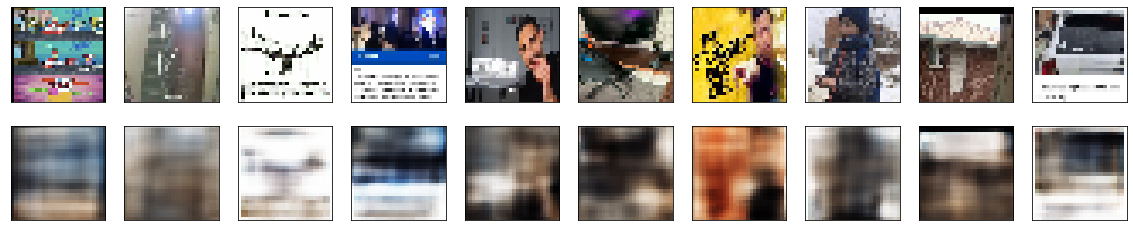

In [21]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

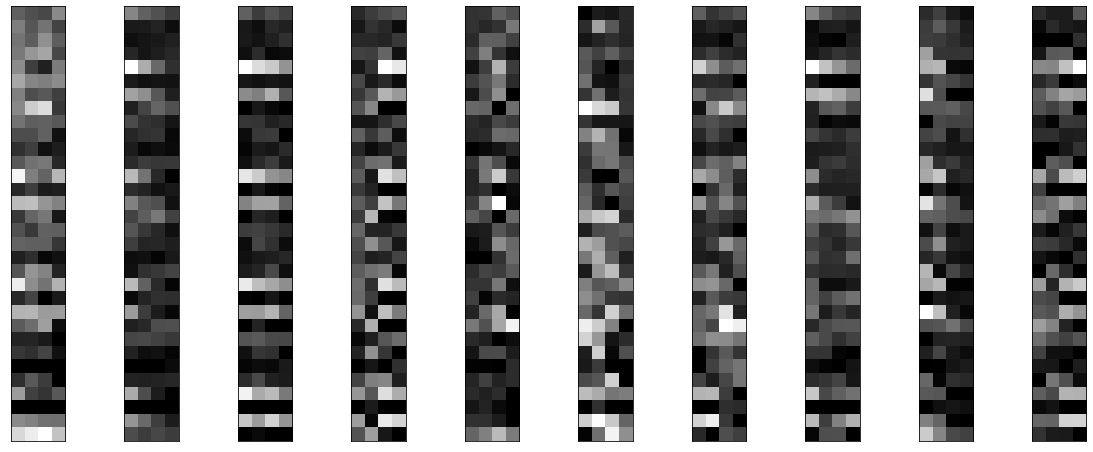

In [206]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
IMAGES_FOLDER = '../scraped_database_tags_new/'
INPUT_SHAPE = (224,224,3)

def load_images(input_shape):
    # images = [np.empty((1, input_shape[0], input_shape[1], input_shape[2]), float)]
    images = []
    
    for file in os.listdir(IMAGES_FOLDER):

        img = image.load_img(IMAGES_FOLDER + file, target_size=input_shape)

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        images.append(x)
        
        if len(images) % 500 == 0:
            print(len(images))

    print("Converting to np array...")
    return np.array(images)

In [7]:
images = load_images(INPUT_SHAPE)

print(images.shape)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
(6007, 1, 224, 224, 3)


In [11]:
img_data=np.rollaxis(images, 1, 0)[0]
print(img_data.shape)

(6007, 224, 224, 3)
